In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sklearn 
import seaborn as sns

In [43]:
!pip install unidecode

You should consider upgrading via the 'C:\Users\Mehr\AppData\Local\Programs\Python\Python39-32\python.exe -m pip install --upgrade pip' command.


In [143]:
alireza_df = pd.read_json('alireza_divar_data.json')
shabani_df = pd.read_json('divar_homes_last_month_92-148.json')
nasiri_df = pd.read_json('divar_homes_last_two_weeks.json')
mobini_df = pd.read_json('divar_houses.json')

In [ ]:
divar_df = pd.concat([alireza_df, shabani_df, nasiri_df, mobini_df])

# removing:
   <p> 1.some columns such as ELEVATOR, TEXTURE,WC, SUNNY,BALCONY,CABINET, SNOWFLAKE, THERMOMETER,
آژانس املاک,انباری ندارد,پارکینگ ندارد
    have lots of null value (80%) you should drop them out cause you can't do anything eith them </p>
    <p>2. featcher 'قیمت هر متر ' it's written in persain and its object and include both string number and (,) it;s to hard to convert it to float
    it's better to drop it out
    ...</p>

In [145]:
columns = [
    'قیمت هر متر','آژانس املاک', 'انباری ندارد', 'پارکینگ ندارد',
    'ELEVATOR', 'TEXTURE', 'WC', 'SUNNY', 'SNOWFLAKE', 'THERMOMETER',
    'BALCONY','CABINET', 'آگهی‌دهنده',
    'وضعیت واحد', 'جهت ساختمان', 'سند', 'آسانسور ندارد', 'PARKING',
    'تعداد واحد در طبقه', 'قیمت کل', 'کد ملی صاحب آگهی'
]

In [146]:
divar_df.drop(columns, axis = 1, inplace = True)

In [147]:
divar_df

,district,business_type,price,متراژ,ساخت,اتاق,طبقه,آسانسور,پارکینگ,انباری
0,992,real-estate-business,3.320000e+09,۱۱۳,۱۳۹۵,۲,۱,True,True,NaN
1,925,real-estate-business,9.200000e+09,۱۱۴,۱۴۰۰,۳,۱,True,True,1.0
2,40,real-estate-business,1.400000e+10,۱۶۵,۱۳۹۷,۳,۲,True,True,1.0
3,925,real-estate-business,8.900000e+09,۱۲۸,۱۳۸۹,۳,۱ از ۴,True,True,1.0
4,925,real-estate-business,1.391000e+09,۱۳۰,۱۴۰۰,۳,۱۱ از ۱۴,True,True,1.0
...,...,...,...,...,...,...,...,...,...,...
21791,64,real-estate-business,1.420000e+10,190,۱۳۸۵,۳,۵,1.0,1.0,1.0
21792,64,real-estate-business,1.105500e+10,165,۱۳۸۷,۳,۴ از ۵,1.0,1.0,1.0
21793,994,real-estate-business,NaN,1000,۱۴۰۰,+۴,۷,1.0,1.0,1.0
21794,300,personal,5.100000e+09,79,۱۴۰۰,۲,۲,1.0,1.0,1.0


### persian columns  to English columns journey:

In [148]:
from unidecode import unidecode
def ConvertNumbers(persian_int):
        return unidecode(f"{persian_int}")   

In [149]:
names_to_change = {
    'متراژ': 'area'
    , 'ساخت': 'construct_date'
    , 'اتاق' : 'rooms'
    , 'طبقه' : 'floor'
    , 'آسانسور' : 'elevator'
    , 'پارکینگ' : 'parking'
    , 'انباری' : 'basement'
}
divar_df.rename(columns = names_to_change, inplace = True)

# fillna:
   the apartments can have elevator , parking ,...  or not
   if not the dataset fills with null value convert them to 0 to have binary value :)

In [150]:
fillna_columns = {'elevator':0.0, 'parking': 0.0, 'basement': 0.0}
divar_df.fillna(fillna_columns, inplace=True)
divar_df.dropna(axis=0, inplace=True)

In [151]:
convert_columns = 'area rooms construct_date floor'.split()
for col in convert_columns:
    divar_df[col] = divar_df[col].apply(ConvertNumbers)

# <h5> floor, room and construct date columns are object, sadly they have both number and string value to </h5>
  <p>  first convert object to number (still it's string don't forget you have to use detype or to_numeric method
    to convert them to float or int)</p>
    


In [153]:
floor_pattern = {'hmkhf': '0', 'zyrhmkhf': '-1'}
room_pattern = {'+4': '5', 'bdwn tq': '0'}
construct_date_pattern = {'qbl z 1370': '1369'}
def replace_pattern(pattern_dict, column_name):  
    for pattern in pattern_dict.keys():
        divar_df[column_name].replace(to_replace=pattern, value=pattern_dict[pattern], inplace=True)

replace_pattern(floor_pattern, 'floor')
replace_pattern(room_pattern, 'rooms')
replace_pattern(construct_date_pattern, 'construct_date')

##### second:
    floor column has two value current floor and total floor of the building; use split method to split them :\

In [158]:
def split_floors(x):
    result = None
    floor = x.split()
    if 'hmkhf' in x:
        result = ('0', floor[-1])
    elif 'zyrhmkhf' in x:
        result = ('-1', floor[-1])
    elif 'byshtr' in x:
        result = (floor[0], floor[-1])
    elif '30+' in x:
        print('here')
        result = ('31', '31')
    else:
        result = re.findall('\d+', x)
    return result

def total_floors(x):
    try:
        return x[1]
    except:
        return x[0]

floors = divar_df['floor'].apply(split_floors)

here
here
here


In [159]:
divar_df['floor'] = floors.apply(lambda x: x[0])
divar_df['total_floor'] = floors.apply(total_floors)

### Categorical:
    business_type has two values(real-estate-business and personal) maybe it'll be use full don't waste it(bacause it doesn't have null)
    just convert it to category to have 0,1 value inplace of each value

In [160]:
divar_df.business_type = pd.Categorical(divar_df['business_type'])
divar_df.business_type = divar_df.business_type.cat.codes

##### <p>descriptions above </p>

In [161]:
convert_to_numeric = 'area rooms floor total_floor construct_date parking elevator'.split()
for i in convert_to_numeric: 
    divar_df[i] = pd.to_numeric(divar_df[i])

#### if you have error in this cell run thirdcell later again

In [162]:
divar_df['per_meter'] = round(divar_df['price'] / divar_df['area'], 2)

In [163]:
divar_df.groupby('district').per_meter.describe()

,count,mean,std,min,25%,50%,75%,max
district,,,,,,,,
40,847.0,9.833697e+07,3.012859e+07,7500000.00,8.000000e+07,9.361702e+07,1.100000e+08,2.500000e+08
44,34.0,8.881523e+07,2.608187e+07,23412698.41,7.333333e+07,8.750000e+07,1.079295e+08,1.400000e+08
45,78.0,8.004311e+07,3.879804e+07,16250000.00,6.000000e+07,7.666667e+07,9.018182e+07,2.000000e+08
48,1413.0,1.003880e+08,6.196347e+07,5300000.00,6.687500e+07,8.800000e+07,1.212121e+08,9.600000e+08
49,120.0,6.010692e+07,1.167100e+07,42372881.36,5.093939e+07,5.777050e+07,6.740370e+07,9.000000e+07
...,...,...,...,...,...,...,...,...
1028,489.0,5.658534e+07,3.855384e+07,11000000.00,4.661017e+07,5.338983e+07,6.250000e+07,6.303030e+08
1030,163.0,3.018686e+07,7.364371e+06,5400000.00,2.934267e+07,3.142857e+07,3.374026e+07,6.000000e+07
1033,41.0,1.731857e+07,4.687285e+06,9000000.00,1.531532e+07,1.648649e+07,2.000000e+07,3.500000e+07


# attention:
    district column is a very usefull featcher in our dataset BUT we can't use till now because it has maeningless values 
    we group them by  per_meter and give them weight by their median 
    now they have a linear relation with per_meter 

In [164]:
district_grouped_by = divar_df.groupby('district').per_meter.median().sort_values()

In [165]:
values = district_grouped_by.index
district_weights = range(1, len(values)+1)
dis_dic = {val: weights for (val, weights) in zip(values, district_weights)}

In [166]:
divar_df.district.replace(dis_dic, inplace=True)

In [167]:
divar_df.district.nunique()

215

#### after all of these activities hopefully now we don't have object featcher anymore:)

In [168]:
divar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139348 entries, 0 to 21795
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   district        139348 non-null  int64  
 1   business_type   139348 non-null  int8   
 2   price           139348 non-null  float64
 3   area            139348 non-null  float64
 4   construct_date  139348 non-null  int64  
 5   rooms           139348 non-null  int64  
 6   floor           139348 non-null  int64  
 7   elevator        139348 non-null  float64
 8   parking         139348 non-null  float64
 9   basement        139348 non-null  float64
 10  total_floor     139348 non-null  int64  
 11  per_meter       139348 non-null  float64
dtypes: float64(6), int64(5), int8(1)
memory usage: 12.9 MB


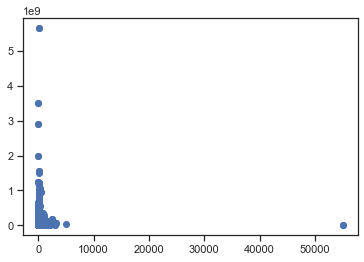

In [169]:
plt.scatter(x=divar_df['area'],y=divar_df['per_meter'])
plt.show()

<AxesSubplot:xlabel='area'>

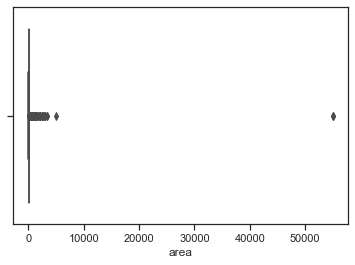

In [170]:
sns.boxplot(data=divar_df,x=divar_df['area'])

In [171]:
a=divar_df.corr()
a['per_meter'].sort_values()

construct_date    0.014423
floor             0.022353
total_floor       0.022353
area              0.091269
basement          0.131608
business_type     0.152517
elevator          0.183102
parking           0.194533
rooms             0.301685
district          0.516520
price             0.710130
per_meter         1.000000
Name: per_meter, dtype: float64

In [174]:
a


,district,business_type,price,area,construct_date,rooms,floor,elevator,parking,basement,total_floor,per_meter
district,1.000000,0.311872,0.444831,0.092357,-0.215445,0.362712,-0.017448,0.196085,0.253385,0.224355,-0.017448,0.516520
business_type,0.311872,1.000000,0.131681,0.017103,0.009829,0.095970,0.023363,0.091708,0.198499,0.179691,0.023363,0.152517
price,0.444831,0.131681,1.000000,0.222776,0.061878,0.486202,0.090341,0.190589,0.190621,0.117972,0.090341,0.710130
area,0.092357,0.017103,0.222776,1.000000,0.028666,0.181986,0.038409,0.066478,0.063403,0.024007,0.038409,0.091269
construct_date,-0.215445,0.009829,0.061878,0.028666,1.000000,0.143783,0.226660,0.539901,0.263271,0.011739,0.226660,0.014423
rooms,0.362712,0.095970,0.486202,0.181986,0.143783,1.000000,0.153987,0.327291,0.337331,0.148753,0.153987,0.301685
floor,-0.017448,0.023363,0.090341,0.038409,0.226660,0.153987,1.000000,0.237596,0.142421,0.050890,1.000000,0.022353
elevator,0.196085,0.091708,0.190589,0.066478,0.539901,0.327291,0.237596,1.000000,0.347206,0.088616,0.237596,0.183102
parking,0.253385,0.198499,0.190621,0.063403,0.263271,0.337331,0.142421,0.347206,1.000000,0.268798,0.142421,0.194533
basement,0.224355,0.179691,0.117972,0.024007,0.011739,0.148753,0.050890,0.088616,0.268798,1.000000,0.050890,0.131608


In [173]:
divar_df.drop('price', axis = 1, inplace = True)

In [175]:
divar_df

,district,business_type,area,construct_date,rooms,floor,elevator,parking,basement,total_floor,per_meter
0,82,1,113.0,1395,2,1,1.0,1.0,0.0,1,2.938053e+07
1,186,1,114.0,1400,3,1,1.0,1.0,1.0,1,8.070175e+07
2,211,1,165.0,1397,3,2,1.0,1.0,1.0,2,8.484848e+07
3,186,1,128.0,1389,3,1,1.0,1.0,1.0,1,6.953125e+07
4,186,1,130.0,1400,3,11,1.0,1.0,1.0,11,1.070000e+07
...,...,...,...,...,...,...,...,...,...,...,...
21789,212,1,200.0,1384,3,3,1.0,1.0,1.0,3,7.500000e+07
21791,212,1,190.0,1385,3,5,1.0,1.0,1.0,5,7.473684e+07
21792,212,1,165.0,1387,3,4,1.0,1.0,1.0,4,6.700000e+07
21794,169,0,79.0,1400,2,2,1.0,1.0,1.0,2,6.455696e+07


#### congratulation your dataset is approximately clean

# models with outliers:

In [181]:
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, learning_curve,cross_val_score

In [176]:
X = divar_df.loc[:, divar_df.columns!='per_meter'].values
y = divar_df['per_meter'].values
x_train, x_test, y_train, y_test = train_test_split(X,y,random_state=5,test_size=0.4)

# model NO1 :
    linear regression with train and test with outliers

In [177]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression()

In [178]:
housing_predictions=lin_reg.predict(x_test)
#output y predict( y^):


In [179]:
housing_predictions

array([30599630.97782743, 50312708.63930476, 53391333.05742884, ...,
       31629541.51068258, 28531435.09421909, 29033611.21078658])

In [180]:
lin_mse = mean_squared_error(y_test , housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

38431516.61065272

In [182]:
scores = cross_val_score(lin_reg, x_train, y_train,
                         scoring="r2", cv=10)
# lin_reg_rmse_scores = np.sqrt(-scores)
# lin_reg_rmse_scores.mean()
scores.mean()

0.4077427232417737

In [183]:
El_reg=ElasticNet(alpha=1.0, l1_ratio=0.99)
El_reg.fit(x_train, y_train)
housing_predictions_El=El_reg.predict(x_test)
El_mse = mean_squared_error(y_test , housing_predictions_El)
El_rmse = np.sqrt(El_mse)
El_rmse

C:\Users\Mehr\AppData\Local\Programs\Python\Python39-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.948e+19, tolerance: 1.707e+16
  model = cd_fast.enet_coordinate_descent(


38431643.53529294

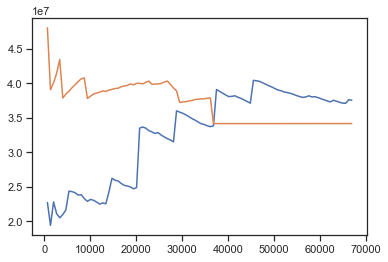

In [195]:
train_sizes, train_scores, valid_scores = learning_curve(LinearRegression(), x_train, y_train, train_sizes=np.linspace(0.01, 1.0, 100), cv=5,
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors)
plt.plot(train_sizes, valid_errors)

In [194]:
xt=np.array([1,0,130,1390,2,2,1,1,1,4]).reshape(1,-1)
lin_reg.predict(xt)

array([4390553.70804381])

# outliers:
    drop out the outlier of area and per meter featcher based on district column with IQR method:

In [ ]:
def detect_outlier(district, column):
    rows = divar_df[divar_df['district'] == district]
    column_values = rows[column]
    Q1 = column_values.quantile(0.25)
    Q3 = column_values.quantile(0.75)
    IQR = Q3 - Q1  
    low_outlier = Q1 - (1.5 * IQR)
    high_outlier = Q3 + (1.5 * IQR)
    lower = rows[rows[column] < low_outlier]
    higher = rows[rows[column] > high_outlier]
    divar_df.drop(lower.index, inplace=True, axis=0)
    divar_df.drop(higher.index, inplace=True, axis=0)

columns = ['area', 'per_meter']
districts = divar_df['district'].unique()
for dis in districts:
    for col in columns:
        detect_outlier(dis, col)

# <h4> this is a new clean csv file the resault of all above code that you don't need to run last cells for cleaning </h4>

In [ ]:
# divar_df.to_csv('cleaned_divar_df.csv')

In [201]:
divar_df_final=pd.read_csv('cleaned_divar_df.csv',sep='\s+')


### drop price
no need to 'price' and 'per_meter' both of them at a time
the label is 'per_meter' so you should drop price because it has affect on your model

In [202]:
divar_df_final.drop('price', axis = 1, inplace = True)
divar_df_final['room_per_area'] = round(divar_df_final['rooms'] / divar_df_final['area'], 2)
divar_df_final

,district,business_type,area,construct_date,rooms,floor,elevator,parking,basement,total_floor,per_meter,room_per_area
0,82,1,113.0,1395,2,1,1.0,1.0,0.0,1,29380530.97,0.02
1,186,1,114.0,1400,3,1,1.0,1.0,1.0,1,80701754.39,0.03
2,211,1,165.0,1397,3,2,1.0,1.0,1.0,2,84848484.85,0.02
4,186,1,130.0,1400,3,11,1.0,1.0,1.0,11,10700000.00,0.02
5,186,1,80.0,1387,2,5,1.0,1.0,1.0,5,43625000.00,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...
21787,212,1,130.0,1384,2,5,1.0,1.0,1.0,5,80769230.77,0.02
21788,212,1,113.0,1385,2,14,1.0,1.0,1.0,14,84955752.21,0.02
21789,212,1,200.0,1384,3,3,1.0,1.0,1.0,3,75000000.00,0.02
21791,212,1,190.0,1385,3,5,1.0,1.0,1.0,5,74736842.11,0.02


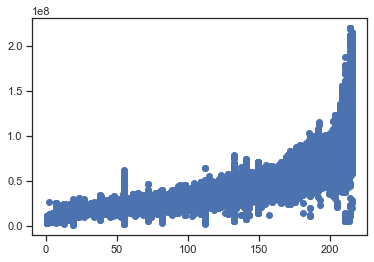

In [203]:
plt.scatter(x=divar_df_final['district'],y=divar_df_final['per_meter'])
plt.show()

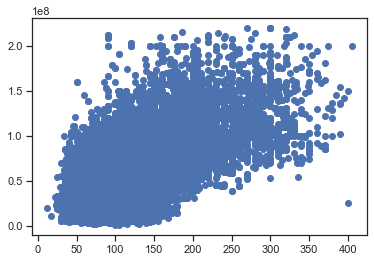

In [204]:
plt.scatter(x=divar_df_final['area'],y=divar_df_final['per_meter'])
plt.show()

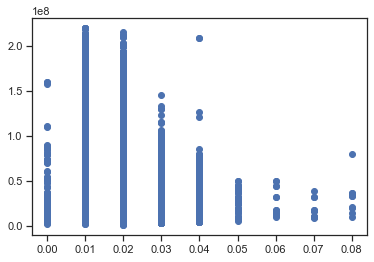

In [205]:
plt.scatter(x=divar_df_final['room_per_area'],y=divar_df_final['per_meter'])
plt.show()

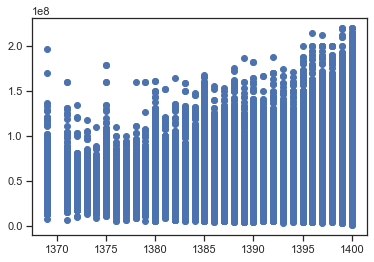

In [260]:
plt.scatter(x=divar_df_final['construct_date'],y=divar_df_final['per_meter'])
plt.show()

<AxesSubplot:xlabel='area'>

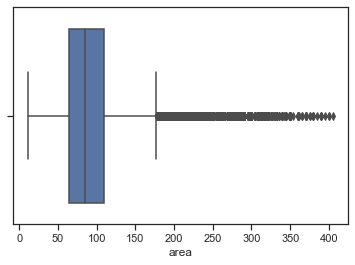

In [207]:
sns.boxplot(data=divar_df_final,x=divar_df_final['area'])

In [206]:
a=divar_df_final.corr()
a['per_meter'].sort_values()

room_per_area    -0.254077
construct_date    0.010288
floor             0.019821
total_floor       0.019821
basement          0.210055
business_type     0.259838
elevator          0.297926
parking           0.317390
rooms             0.473089
area              0.648326
district          0.829360
per_meter         1.000000
Name: per_meter, dtype: float64

### resault of corr without outliers
in comparison with cell 93 :
    the correlations of per meter with some faetchers are increase we have new column room_per_area    it seems that is usefull 
    

# model with out outliers:

# split data frame to test and train

In [208]:
X = divar_df_final.loc[:, divar_df_final.columns!='per_meter'].values
y = divar_df_final['per_meter'].values
X.shape

(113458, 11)

In [209]:
x_train, x_test, y_train, y_test = train_test_split(X,y,random_state=4,test_size=0.2)
x_train.shape

(90766, 11)

In [210]:
x_test.shape

(22692, 11)

In [114]:
y_train.shape

(111478,)

In [212]:
y_test.shape

(22692,)

# model NO1 :
    polynomial linear regression with train and test 

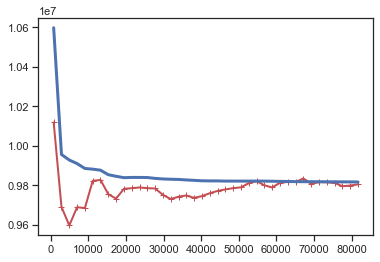

In [213]:
polynomial_regression_pipline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression() 
)

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression_pipline, x_train, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=10,
    scoring="neg_root_mean_squared_error"
)

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

In [224]:
train_errors.mean()

9783785.529701438

# model NO2 :
    linear regression with train and test 

In [221]:
from sklearn.metrics import mean_squared_error, r2_score



regr = LinearRegression()

regr.fit(x_train, y_train)

y_pred = regr.predict(x_test)
mse= mean_squared_error(y_test, y_pred)
print("Coefficients: \n", regr.coef_)
print("Mean squared error: %.2f" % np.sqrt(mse))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))


# plt.scatter(x_test, y_test, color="black")
# plt.plot(x_test, y_pred, color="blue", linewidth=3)

# plt.xticks(())
# plt.yticks(())

# plt.show()

Coefficients: 
 [ 2.85858376e+05 -5.59431410e+04  3.61100680e+05  5.72063236e+05
 -1.08191331e+07 -1.27304789e+05 -9.50890322e+05  6.91822134e+05
 -1.22908384e+05 -1.27304789e+05  4.57063867e+08]
Mean squared error: 12102578.19
Coefficient of determination: 0.80


In [234]:
# from sklearn.model_selection import cross_val_score

# scores = cross_val_score(lin_reg, x_train, y_train,
#                          scoring="r2", cv=10)
# lin_reg_rmse_scores = np.sqrt(-scores)
# lin_reg_rmse_scores.mean()
scores.mean()

0.4077427232417737

# model NO3:
elastic net regression with train and test

In [228]:
El_reg=ElasticNet(alpha=1.0, l1_ratio=0.99)
El_reg.fit(x_train, y_train)

C:\Users\Mehr\AppData\Local\Programs\Python\Python39-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.778e+18, tolerance: 6.818e+15
  model = cd_fast.enet_coordinate_descent(


ElasticNet(l1_ratio=0.99)

In [229]:
housing_predictions_El=El_reg.predict(x_test)
#output y predict( y^):

In [230]:
El_mse = mean_squared_error(y_test , housing_predictions_El)
El_rmse = np.sqrt(El_mse)


In [232]:
El_rmse

12180395.45007933

In [231]:
np.corrcoef(y_test,housing_predictions_El)

array([[1.        , 0.89251625],
       [0.89251625, 1.        ]])

In [235]:


scores = cross_val_score(El_reg, x_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
El_reg_rmse_scores = np.sqrt(-scores)
El_reg_rmse_scores

C:\Users\Mehr\AppData\Local\Programs\Python\Python39-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.102e+18, tolerance: 6.149e+15
  model = cd_fast.enet_coordinate_descent(
C:\Users\Mehr\AppData\Local\Programs\Python\Python39-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.121e+18, tolerance: 6.139e+15
  model = cd_fast.enet_coordinate_descent(
C:\Users\Mehr\AppData\Local\Programs\Python\Python39-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

array([12233548.68438158, 12078156.89092382, 12323004.73993495,
       12154943.76565959, 12111804.51099438, 12399547.71920658,
       12538645.19990124, 12190856.54194599, 12212714.9649257 ,
       12303915.26420818])

# scale up:

In [236]:
from sklearn import preprocessing
scale_min_max=preprocessing.MinMaxScaler()
x_train_scale=scale_min_max.fit_transform(x_train,y_train)
x_test_scale=scale_min_max.transform(x_test)

In [237]:
pd.DataFrame(x_train_scale)

,0,1,2,3,4,5,6,7,8,9,10
0,0.504673,1.0,0.112272,0.677419,0.2,0.064516,1.0,1.0,1.0,0.064516,0.250
1,0.406542,1.0,0.052219,0.741935,0.2,0.032258,1.0,1.0,1.0,0.032258,0.250
2,0.761682,1.0,0.214099,0.903226,0.4,0.129032,1.0,1.0,1.0,0.129032,0.250
3,0.962617,1.0,0.169713,0.516129,0.4,0.161290,1.0,1.0,1.0,0.161290,0.250
4,0.799065,1.0,0.135770,0.258065,0.4,0.096774,0.0,1.0,1.0,0.096774,0.375
...,...,...,...,...,...,...,...,...,...,...,...
90761,0.943925,0.0,0.073107,0.516129,0.2,0.064516,1.0,1.0,1.0,0.064516,0.250
90762,0.028037,1.0,0.125326,0.677419,0.4,0.064516,0.0,1.0,1.0,0.064516,0.375
90763,0.789720,1.0,0.138381,0.677419,0.4,0.032258,1.0,1.0,1.0,0.032258,0.375
90764,0.827103,1.0,0.245431,0.580645,0.6,0.129032,1.0,1.0,1.0,0.129032,0.375


In [238]:
x_test_scale

array([[0.78971963, 1.        , 0.1618799 , ..., 1.        , 0.03225806,
        0.25      ],
       [0.78971963, 1.        , 0.24543081, ..., 1.        , 0.06451613,
        0.375     ],
       [0.76635514, 1.        , 0.17754569, ..., 1.        , 0.06451613,
        0.25      ],
       ...,
       [0.78971963, 1.        , 0.15926893, ..., 1.        , 0.16129032,
        0.25      ],
       [0.78971963, 1.        , 0.10443864, ..., 1.        , 0.09677419,
        0.375     ],
       [0.79439252, 1.        , 0.21409922, ..., 1.        , 0.03225806,
        0.25      ]])

# model NO4:
linear regression with min max scale train  and min max scale test

In [254]:
regr = LinearRegression()
regr.fit(x_train_scale, y_train)
y_pred_scale = regr.predict(x_test_scale)
mse= mean_squared_error(y_test, y_pred_scale)
print("Coefficients: \n", regr.coef_)
print("Mean squared error: %.2f" % np.sqrt(mse))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_scale))

Coefficients: 
 [ 6.11736925e+07 -5.59431410e+04  1.38301561e+08  1.77339603e+07
 -5.40956657e+07 -3.94644847e+06 -9.50890322e+05  6.91822134e+05
 -1.22908384e+05 -3.94644847e+06  3.65651093e+07]
Mean squared error: 12102578.19
Coefficient of determination: 0.80


# model NO5:
elastic regression with min max scale train and min max scale test

In [247]:
El_reg.fit(x_train_scale, y_train)

ElasticNet(l1_ratio=0.99)

In [248]:
El_reg.fit(x_train_scale, y_train)
El_predictions_scale=El_reg.predict(x_test_scale)
El_mse = mean_squared_error(y_test , El_predictions_scale)
El_rmse = np.sqrt(El_mse)

In [249]:
El_mse = mean_squared_error(y_test , El_predictions_scale)
El_rmse = np.sqrt(El_mse)
El_rmse

12926303.67812849

# model NO6:
ridge net regression with train and test

In [251]:
ridge_reg = Ridge(alpha=0.99)
ridge_reg.fit(x_train, y_train)
ridge_reg_predictions=ridge_reg.predict(x_test)

In [252]:
ridge_reg_mse = mean_squared_error(y_test , ridge_reg_predictions)
ridge_reg_rmse = np.sqrt(ridge_reg_mse)
ridge_reg_rmse

12112364.325009052

# model NO7:
 Polynomial regression with train scale and test scale

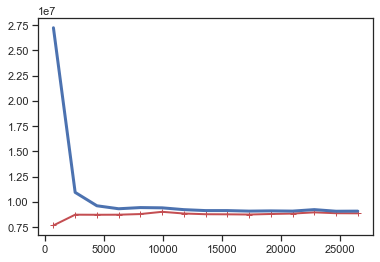

In [241]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_regression_pipline = make_pipeline(
    PolynomialFeatures(degree=3),
    LinearRegression() 
)

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression_pipline, x_train_scale, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error"
)

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

In [243]:
train_errors

array([7678173.83474705, 8740499.51554072, 8732289.72613757,
       8738810.16051414, 8803556.9472429 , 9025649.17482283,
       8857573.55219155, 8786983.49048504, 8777758.74998952,
       8756535.03864215, 8809973.17419273, 8851476.15906294,
       8972129.28848981, 8886053.93920081, 8876742.21080243,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan])

# this model has the best prediction

In [245]:
polynomial_pipline = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

polynomial_pipline.fit(x_train_scale, y_train)
y_poly_predict = polynomial_pipline.predict(x_test_scale)
poly_rmse = mean_squared_error(y_test, y_poly_predict)
poly_rmse=np.sqrt(poly_rmse)

In [246]:
poly_rmse

9834122.270267526

# model NO8:
    SGD regression with scale train and test

In [259]:

sgd =SGDRegressor(penalty='l1', max_iter=10000, tol=1e-5, eta0=0.1, random_state=45)
sgd.fit(x_train_scale, y_train)
y_sgd_predict = sgd.predict(x_test_scale)
mse= mean_squared_error(y_test, y_sgd_predict)
print("Coefficients: \n", sgd.coef_)
print("Mean squared error: %.2f" % np.sqrt(mse))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_sgd_predict))

Coefficients: 
 [ 6.11569555e+07  2.53136023e+04  1.38336478e+08  1.80542595e+07
 -5.38704284e+07 -3.86066118e+06 -7.88634082e+05  1.05155251e+06
  8.20836673e+05 -3.86066118e+06  3.67981763e+07]
Mean squared error: 12319231.34
Coefficient of determination: 0.79
